# Coastal Storm Hazard
This notebook calculates the urban risk index for Coastal Storm (CST)
hazard.  The URI calculation has three components: expected loss, social vulnerability, and resilience capacity.  

## 1. Expected Loss
The CST hazard expected loss (ESL) includes consequences for the following receptors and marginal losses.
 * Various / Wind Damage
 * People / Deaths
 * People / Dislocation
 * Buildings / Flooding

#### 1a. Various / Wind Damage
The annualized loss due to wind damage from coastal storms was estimated for each census tract using HAZUS model results provided by NYCEM.  The damage assessment includes damage to buildings, building contents, inventory, and loss of income. 

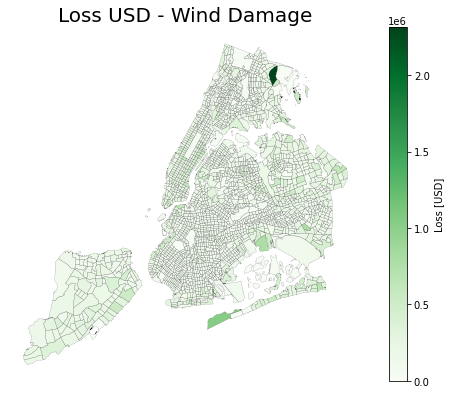

In [1]:
from MISC import params_1 as params
from MISC import utils_1 as utils
from MISC import plotting_1 as plotting
from CLASSES import class_EL_SV_CR_1 as URI
import matplotlib.pyplot as plt
import geopandas as gpd
import os
utils.set_home()
hazard_name = "CST"

#create ESL class and add loss
path_loss =   params.PATHNAMES.at['ESL_CST_hazus_loss', 'Value']
gdf_ESL_deaths = gpd.read_file(path_loss)
ESL = URI.ESL(hazard_name = hazard_name)
ESL.add_consequence("Wind", "Various", gdf_ESL_deaths)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Wind"]["map_tract"], 'Loss USD - Wind Damage')

#### 1b. People / Deaths
The HH&C database was used to count the average of deaths due to "coastal storm" events over the past 20 years. The 
 HH&C database documented 43 deaths, all from Hurricane Sandy.  The 
deaths were valuated and distributed by population.  

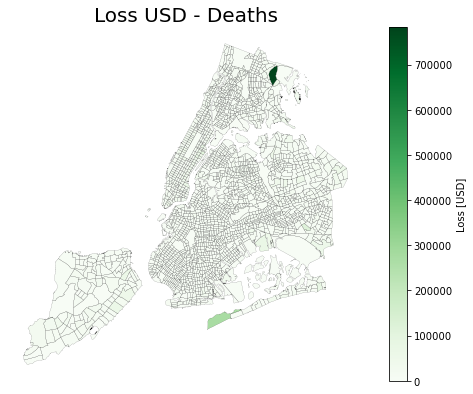

In [2]:
#all loss to ESL class
path_loss =   params.PATHNAMES.at['ESL_CST_deaths_loss', 'Value']
gdf_loss = gpd.read_file(path_loss)
ESL.add_consequence("Death", "People", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Death"]["map_tract"], 'Loss USD - Deaths')

#### 1c. People / Dislocation
Coastal flooding simulations that predict the maximum depth of flooding across NYC for different category storms 
were used to estimate the annualized risk of dislocation.  FEMA values were used to valuate dislocation assuming an average 
duration of 30 days.  

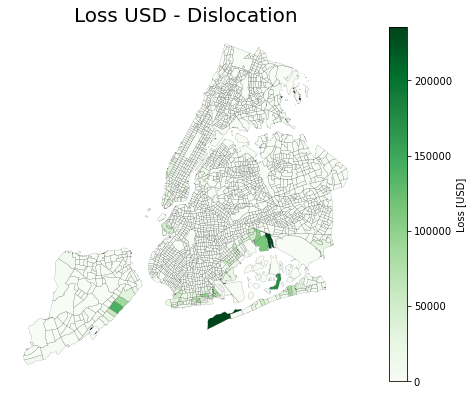

In [3]:
#all loss to ESL class
path_loss =   params.PATHNAMES.at['ESL_CST_dislocation_loss', 'Value']
gdf_loss = gpd.read_file(path_loss)
ESL.add_consequence("Disloc", "People", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Disloc"]["map_tract"], 'Loss USD - Dislocation')

#### 1d. Buildings / Flooding
A HAZUS simulation was used to calculate annualized lossed to property due to flooding.  

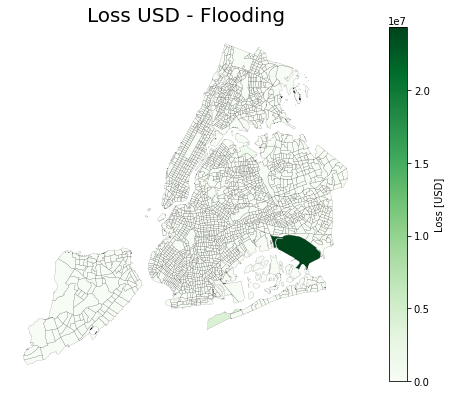

In [4]:
#all loss to ESL class
path_loss =   params.PATHNAMES.at['ESL_FLD_hazus_loss', 'Value']
gdf_loss = gpd.read_file(path_loss)
ESL.add_consequence("Flood", "Buildings", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Flood"]["map_tract"], 'Loss USD - Flooding')

#### 1e. Expected Loss Total
The total expected losses are the sum of losses from each individual consequence.  

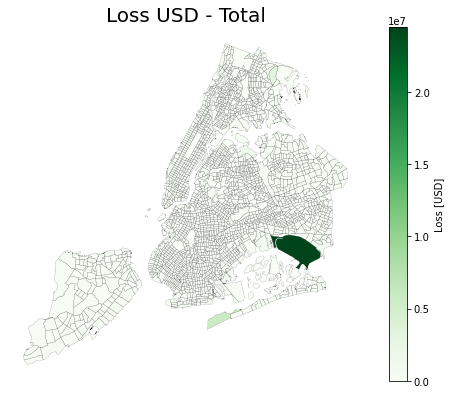

In [5]:
#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\ESL\ESL_{}_tract.shp'.format(hazard_name, hazard_name)
ESL.ESL_map.to_file(path_save)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.ESL_map, 'Loss USD - Total')

## 2. Social Vulnerability Score
The Social Vulnerability is based on the CDC social vulnerability index.  

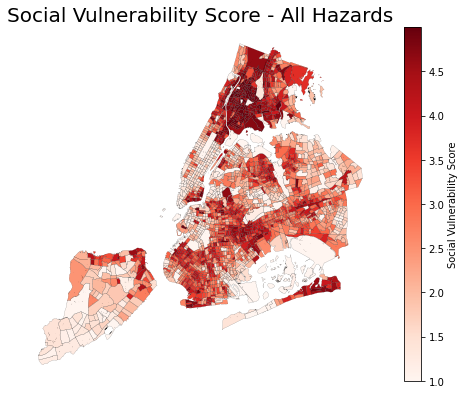

In [6]:
path_SOV = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\SOV\SOV_tract.shp'
gdf_SOV = gpd.read_file(path_SOV)
SOV = URI.SOV(hazard_name = hazard_name, map_tract = gdf_SOV)


#plot
plotting.plot_SOV_nb(SOV.SOV_map)

## 3. Resilience Capacity Score
The Resilience Capacity is the sum of four scores:
- Community Capital
- Mitigation Landscape
- Response Capacity
- Recovery Resources


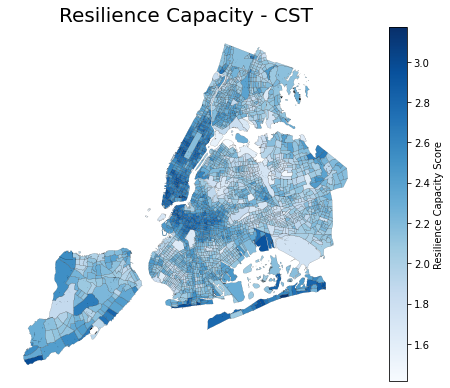

In [7]:
path_RCA = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\RCA\RCA_{}_tract.shp'.format(hazard_name)
gdf_RCA = gpd.read_file(path_RCA)
RCA = URI.RCA(hazard_name=hazard_name, map_tract=gdf_RCA)
#
plotting.plot_RCA_nb('CST', RCA.RCA_map)

## 4. Calculate URI Score
The URI equation is URI = ESL * SOV / RCA.  The result is clustered into a score of 1 (low) to 5 (high).

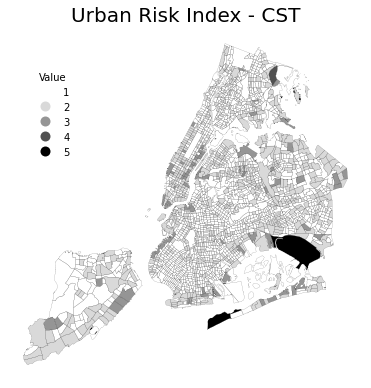

In [8]:
URI_HAZ = URI.URI(hazard_name=hazard_name, ESL=ESL, SOV=SOV, RCA=RCA)
URI_HAZ.calc_URI()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\URI\URI_{}_tract.shp'.format(hazard_name, hazard_name)
URI_HAZ.URI_map.to_file(path_save)
URI_HAZ.save_URI_FULL()
plotting.plot_URI_nb(hazard_name, URI_HAZ.URI_map)


